In [1]:
import numpy as np
import sys, os
import matplotlib.pyplot as plt
from scipy.integrate import quad, nquad
from scipy.interpolate import interp1d
from astropy import units as u
from astropy.coordinates import SkyCoord
from tqdm import *
import pandas as pd
from scipy.stats import chi2
from scipy.special import sph_harm 
from scipy.special import lpmv
import healpy as hp
from healpy.sphtfunc import map2alm

%matplotlib inline
%load_ext autoreload
%autoreload

## Define

In [2]:
def fn_Yharm(l, m, theta, phi):
    return sph_harm(m, l, phi, theta)

def fn_Yharm_map(l,m):
    """spherical harmonic map over healpix with nside defined"""
    tmp_map = np.zeros(npix, dtype=np.complex)
    if l >= 0:  # To avoid getting nan outputs when there are l = -1 calls
        for i in np.arange(npix):
            tmp_map[i] += fn_Yharm(l, m, pix_coords[i,0], pix_coords[i,1])
    return tmp_map

def fn_c_coeff(c_idx,l,m):
    if c_idx == 1:
        return np.sqrt((l + 1) * (l - m) * (l + m) / ( l * (2 * l - 1) * (2 * l + 1) + 1e-10) )
    elif c_idx == 2:
        return -np.sqrt(l * (l - m + 1) * (l + m + 1) / ((l + 1) * (2 * l + 3) * (2 * l + 1) + 1e-10))
    elif c_idx == 3:
        return 1.j * m / np.sqrt(l * (l + 1) + 1e-10)
    
def fn_sin_map():
    return np.sin(pix_coords[:, 0])

def fn_sin_inv_map():
    tmp_map = np.zeros(npix, dtype=np.complex)
    for i in np.arange(npix):
        sin_val = np.sin(pix_coords[i,0])
        if np.abs(sin_val) > 0:
            tmp_map[i]= 1 / sin_val
        else:
            tmp_map[i]= 1e40    
    return tmp_map

def fn_Aharm_map(l,m):
    """A harmonic map over healpix with nside defined"""
    tmp_map = np.zeros(npix,dtype=np.complex)
    if l > 0:  # To avoid getting nan outputs when there are l = -1 calls
        if l > np.abs(m):
            for i in np.arange(npix):
                tmp_map[i] += fn_c_coeff(1, l, m) * fn_Yharm(l - 1, m, pix_coords[i,0], pix_coords[i, 1]) + fn_c_coeff(2, l, m) * fn_Yharm(l + 1, m, pix_coords[i,0], pix_coords[i,1])
        elif l == abs(m):  # To avoid getting nan outputs when l-1 < abs(m)
            for i in np.arange(npix):
                tmp_map[i] += fn_c_coeff(2, l, m) * fn_Yharm(l + 1, m, pix_coords[i, 0], pix_coords[i, 1])
    elif l==0:
        for i in np.arange(npix):
            tmp_map[i] += fn_c_coeff(2, l, m) * fn_Yharm(l + 1, m, pix_coords[i,0], pix_coords[i,1])
    return tmp_map

def fn_Bharm_map(l,m):
    """B harmonic map over healpix with nside defined"""
    tmp_map = np.zeros(npix,dtype=np.complex)
    if l > 0:  # To avoid dividing by zero
        for i in np.arange(npix):
            tmp_map[i] += fn_c_coeff(3, l, m) * fn_Yharm(l, m, pix_coords[i,0], pix_coords[i,1])
    return tmp_map

def fn_Psiharm_map(l,m):
    """Psi harmonic map over healpix with nside defined"""
    theta_comp_map = -fn_sin_inv_map() * fn_Aharm_map(l, m)
    phi_comp_map = -fn_sin_inv_map() * fn_Bharm_map(l, m)
    return np.transpose([theta_comp_map, phi_comp_map])

In [3]:
from healpy.sphtfunc import Alm

def fn_alm_getidx(lmax,l,m):
    if m >= 0:
        return Alm.getidx(lmax,l,m)
    else:
        return round(0.5*lmax**2 + 1.5*lmax + 1) - (lmax+1) + Alm.getidx(lmax,l,abs(m))
    
def fn_alm_getlm(lmax,idx):
    if idx < round(0.5*lmax**2 + 1.5*lmax + 1):
        return Alm.getlm(lmax,idx)
    else:
        lm_pos =  Alm.getlm(lmax, idx - round(0.5*lmax**2 + 1.5*lmax + 1) + (lmax+1))
        return (lm_pos[0], -lm_pos[1])
    
def fn_complexmap2alm(map):
    alm_real = map2alm(np.real(map))
    alm_imag = map2alm(np.imag(map))
    alm_total = alm_real + alm_imag*1j
       
    for idx_lower in range(lmax+1, alm_real.size):
        alm_total = np.concatenate(( alm_total, [(-1)**Alm.getlm(lmax,idx_lower)[1] * (alm_real[idx_lower]-alm_imag[idx_lower]*1j)] ))    
        
    return alm_total

In [4]:
def fn_mat_Fisher1(weights_map):
    mat_Ptilde = fn_mat_Ptilde(weights_map)
    return 0.5 * np.real(mat_Ptilde * np.transpose(mat_Ptilde))

In [5]:
def fn_mat_Fisher1_inv(mat_fisher1):
    matfish_block = mat_fisher1[1:, 1:]
    matfish_block_inv = np.real(np.linalg.inv(matfish_block))
    return np.pad(matfish_block_inv, ((1, 0),(1, 0)), 'constant')

In [29]:
def fn_mat_Psitilde(weights_map):
    prefactor_map = -fn_sin_inv_map() * weights_map
    mat_Psitilde_1 = np.zeros(((lmax + 1) ** 2, (lmax + 1) ** 2),dtype='complex')
    mat_Psitilde_2 = np.zeros(((lmax + 1) ** 2, (lmax + 1) ** 2),dtype='complex')
    
    for idx in tqdm_notebook(range((lmax + 1)**2)):
        l, m = fn_alm_getlm(lmax,idx)[0].item(), fn_alm_getlm(lmax,idx)[1].item()
        psiharm_map1, psiharm_map2 = fn_Psiharm_map(l,m)[:, 0], fn_Psiharm_map(l,m)[:, 1]
        mat_Psitilde_1[idx] = fn_complexmap2alm(prefactor_map * psiharm_map1)
        mat_Psitilde_2[idx] = fn_complexmap2alm(prefactor_map * psiharm_map2)
        
    return mat_Psitilde_1, mat_Psitilde_2

def fn_mat_Ptilde(weights_map):
    
    mat_Psitilde_1, mat_Psitilde_2 = fn_mat_Psitilde(weights_map)
    c1vec = np.zeros(lmax**2, dtype='complex')  # Create coefficient vectors
    c2vec = np.zeros(lmax**2, dtype='complex')
    c3vec = np.zeros(lmax**2, dtype='complex')
    
    for idx in range(lmax ** 2):  # Only go up to lmax-1 to avoid getting out of range on the l+1 recursion
        l, m = fn_alm_getlm(lmax - 1, idx)[0].item(), fn_alm_getlm(lmax - 1, idx)[1].item() 
        c1vec[idx] = fn_c_coeff(1, l, m) * np.min([l,1])  # Multiplier to handle l==0 exception
        c2vec[idx], c3vec[idx] =  fn_c_coeff(2, l, m), fn_c_coeff(3, l, np.abs(m))  # Why abs(m)?
        
    vec_idx_zero = np.zeros(lmax ** 2, dtype='int')  # Create permutation vectors to select parts of Psitilde matrices
    vec_idx_minus = np.zeros(lmax ** 2, dtype='int')
    vec_idx_plus = np.zeros(lmax ** 2, dtype='int')
    
    for idx in range(lmax**2):
        l, m = fn_alm_getlm(lmax - 1,idx)[0].item(), fn_alm_getlm(lmax - 1, idx)[1].item()
        vec_idx_zero[idx] = fn_alm_getidx(lmax, l, m)
        vec_idx_minus[idx] = fn_alm_getidx(lmax, l - 1, m)
        vec_idx_plus[idx] = fn_alm_getidx(lmax, l + 1, m)
        
    mat_Psitilde_2_zero = -np.transpose(c3vec * np.transpose(mat_Psitilde_2[vec_idx_zero][:, vec_idx_zero]))
    mat_Psitilde_1_minus = np.transpose(c1vec * np.transpose(mat_Psitilde_1[vec_idx_zero][:, vec_idx_minus]))
    mat_Psitilde_1_plus = np.transpose(c2vec * np.transpose(mat_Psitilde_1[vec_idx_zero][:, vec_idx_plus]))
    mat_Ptilde = mat_Psitilde_1_minus + mat_Psitilde_1_plus + mat_Psitilde_2_zero
    return mat_Ptilde

In [30]:
def fn_mat_num1_sig(data_map_b, data_map_l, weights_map):
    dtilde_map_b = fn_sin_inv_map() * weights_map * data_map_b
    dtilde_map_l = fn_sin_inv_map() * weights_map * data_map_l
    dtilde_b_lm = fn_complexmap2alm(dtilde_map_b)
    dtilde_l_lm = fn_complexmap2alm(dtilde_map_l)
    c1vec = np.zeros(lmax ** 2, dtype='complex')  # Create coefficient vectors
    c2vec = np.zeros(lmax ** 2, dtype='complex')
    c3vec = np.zeros(lmax ** 2, dtype='complex')
    for idx in range(lmax ** 2):  # Only go up to lmax - 1 to avoid getting out of range on the l + 1 recursion
        l, m = fn_alm_getlm(lmax - 1, idx)[0].item(), fn_alm_getlm(lmax - 1, idx)[1].item() 
        c1vec[idx] = fn_c_coeff(1, l, m) * np.min([l, 1])  # Multiplier to handle l==0 exception
        c2vec[idx], c3vec[idx] =  fn_c_coeff(2, l, m), fn_c_coeff(3, l, m)
    vec_idx_zero = np.zeros(lmax ** 2, dtype='int')  # Create permutation vectors to select parts of A and B matrices
    vec_idx_minus = np.zeros(lmax ** 2, dtype='int')
    vec_idx_plus = np.zeros(lmax ** 2, dtype='int')
    for idx in range(lmax ** 2):
        l, m = fn_alm_getlm(lmax - 1, idx)[0].item(), fn_alm_getlm(lmax - 1, idx)[1].item()
        vec_idx_zero[idx] = fn_alm_getidx(lmax, l, m)
        vec_idx_minus[idx] = fn_alm_getidx(lmax, l - 1, m)
        vec_idx_plus[idx] = fn_alm_getidx(lmax, l + 1, m)
    dtilde_l_lm_zero  = dtilde_l_lm[vec_idx_zero]
    dtilde_b_lm_minus = dtilde_b_lm[vec_idx_minus]
    dtilde_b_lm_plus  = dtilde_b_lm[vec_idx_plus]
    amp = c1vec * dtilde_b_lm_minus + c2vec * dtilde_b_lm_plus - c3vec * dtilde_l_lm_zero
    return np.real(amp * np.conjugate(amp))

In [31]:
def fn_arr_pow_spec(pow_spec):  # Converts idx components into (l,m) array
    lmax = (np.sqrt(pow_spec.shape[0]) - 1).astype(int)
    tmp_mat = np.zeros((lmax + 1, lmax + 1)) + 1e-100
    for l in range(lmax + 1):
        for m in range(l + 1):
            idx = fn_alm_getidx(lmax, l, m)
            tmp_mat[m, l] += pow_spec[idx]
    return tmp_mat

## Load

In [8]:
quasars_pd = pd.read_csv("../data/quasars_phot.csv")
quasars_pd.columns.values

array(['source_id', 'parallax', 'parallax_error', 'ra', 'dec', 'ra_error',
       'dec_error', 'pmra', 'pmdec', 'pmra_error', 'pmdec_error',
       'pmra_pmdec_corr', 'astrometric_gof_al',
       'astrometric_matched_observations', 'visibility_periods_used',
       'astrometric_sigma5d_max', 'radial_velocity',
       'radial_velocity_error', 'astrometric_n_good_obs_al',
       'astrometric_n_bad_obs_al', 'astrometric_excess_noise',
       'astrometric_excess_noise_sig', 'astrometric_weight_al',
       'astrometric_chi2_al', 'matched_observations', 'phot_g_mean_mag',
       'phot_bp_rp_excess_factor'], dtype=object)

In [9]:
ra = quasars_pd['ra'].values
dec = quasars_pd['dec'].values
pmra = quasars_pd['pmra'].values
pmdec = quasars_pd['pmdec'].values
pmra_error = quasars_pd['pmra_error']
pmdec_error = quasars_pd['pmdec_error']
pm_var = 0.5*(pmra_error**2 + pmdec_error**2)

In [10]:
quasars_icrs = SkyCoord(ra=ra*u.deg, 
                        dec=dec*u.deg, 
                        pm_ra_cosdec=pmra*u.mas/u.yr, 
                        pm_dec=pmdec*u.mas/u.yr, 
                        frame='icrs')
quasars_gal = quasars_icrs.transform_to('galactic')
l_gal = quasars_gal.l.value
b_gal = quasars_gal.b.value
pm_l_gal = quasars_gal.pm_l_cosb.value
pm_b_gal = quasars_gal.pm_b.value

In [11]:
nside = 16
npix = hp.nside2npix(nside)
lmax = 3*nside-1
print('npix =', npix, ', lmax =', lmax, end=None)
#map = np.arange(npix)
#hp.mollview(map, title="Mollview image RING", xsize=2000)

q_pix = hp.ang2pix(nside,np.deg2rad(90-b_gal),np.deg2rad(l_gal))

pix_coords = np.asarray(hp.pixelfunc.pix2ang(nside,np.arange(npix))).transpose()

quasars_map = np.zeros(hp.nside2npix(nside))
pm_N_map = np.zeros(hp.nside2npix(nside))
pm_l_map = np.zeros(hp.nside2npix(nside))
pm_b_map = np.zeros(hp.nside2npix(nside))

npix = 3072 , lmax = 47


In [12]:
for idx, ipix in enumerate(tqdm_notebook((q_pix))):
    quasars_map[ipix] += 1
    pm_N_map[ipix] += 1/pm_var[idx]
    pm_l_map[ipix] += pm_l_gal[idx]/pm_var[idx]
    pm_b_map[ipix] += pm_b_gal[idx]/pm_var[idx]

pm_l_map /= (pm_N_map + 10**(-10))
pm_b_map /= (pm_N_map + 10**(-10))
pm_mag_map = np.sqrt(pm_l_map**2 + pm_b_map**2)
pm_N_map = np.reciprocal(pm_N_map + 10**(-10))

## Analyze

In [13]:
#weights_map = 1
weights_map = pm_N_map**(-1)
mat_fisher1 = fn_mat_Fisher1(weights_map)
mat_fisher1_inv = fn_mat_Fisher1_inv(mat_fisher1)

In [14]:
#l_fake, m_fake = 7,2
#data_map_b, data_map_l = fn_Psiharm_map(l_fake,m_fake)[:,0],fn_Psiharm_map(l_fake,m_fake)[:,1]
data_map_b, data_map_l = pm_b_map, pm_l_map
mat_num1_sig = fn_mat_num1_sig(data_map_b, data_map_l,weights_map)
mat_pow1_spec = (1/2) * mat_fisher1_inv @ mat_num1_sig

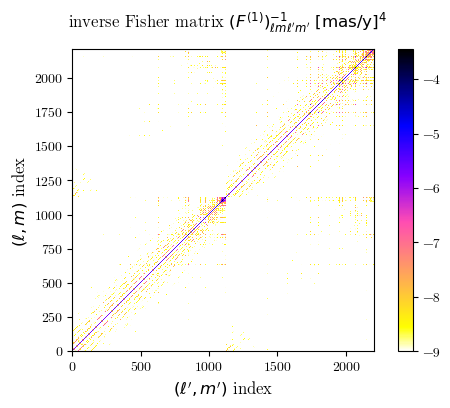

In [16]:
fig_mat_fisher1_inv = plt.figure(num=None, figsize=(6,4), dpi=100, facecolor='w', edgecolor='k')
plt.imshow(np.log10(abs(mat_fisher1_inv+10**(-30))), origin='lower', vmin=-9, cmap = 'gnuplot2_r');
plt.suptitle('inverse Fisher matrix $(F^{(1)})^{-1}_{\ell m \ell^{\prime} m^\prime}$ $[\mathrm{mas/y}]^{4}$', fontsize=12)
plt.xlabel('$(\ell^\prime,m^\prime)$ index', fontsize=12)
plt.ylabel('$(\ell,m)$ index', fontsize=12)
plt.colorbar()
plt.show()
# fig_mat_fisher1_inv.savefig('mat_fisher1_inv.pdf')

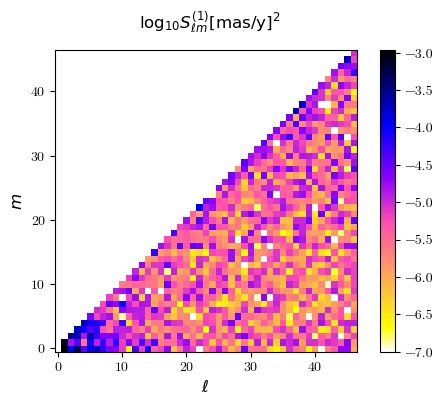

In [19]:
fig_pow1_spec = plt.figure(num=None, figsize=(6,4), dpi=100, facecolor='w', edgecolor='k')
plt.imshow(np.log10(abs(fn_arr_pow_spec(mat_pow1_spec))),  origin='lower', vmin=-7, vmax=None, cmap='gnuplot2_r');
plt.suptitle('$\log_{10}S^{(1)}_{\ell m} [\mathrm{mas}/\mathrm{y}]^2$', fontsize=12)
plt.xlabel('$\ell$', fontsize=12)
plt.ylabel('$m$', fontsize=12)
plt.colorbar()
plt.show()
# fig_pow1_spec.savefig('pow1_spec.pdf')

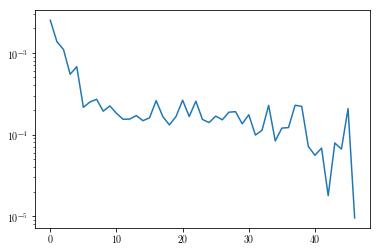

In [26]:
plt.plot(np.sum(abs(fn_arr_pow_spec(mat_pow1_spec)), axis=1))
plt.yscale("log")